In [2]:
using ITensors, ITensorMPS, Plots
using Plots.PlotMeasures

In [77]:
N = 51 #Number of lattice sites per dimension
d = 1 #Number of spatial dimensions
dx = 1 #Lattice spacing

n_0 = round(Int, ((N-1)/2)) #Index of thepoint at the center of the lattice.
dp = (2*pi)/(N*dx) #Discrete change in momentum
p_i = range(1/2*dp, stop = dp*(N+1/2), length = (N+1))[1:end-1]

om_i = Float64[] #List of omega values for each lattice site (eq. 12)
for i in 1:N
    push!(om_i, (2/dx)*abs(sin(p_i[i]*dx/2)))
end

In [78]:
H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
for i in 1:N
    H += (om_i[i]*dp)/(2pi), "a", i, "a†", i
    H += (om_i[i]*dp)/(2pi)*(1/2)*(2pi/dp), "Id", i
end

sites = siteinds("Boson", N; dim=9); #Create ITensor "SFT" sites

In [79]:
function MakeState(excitation_dict)
    for i in keys(excitation_dict)
        if i > N
            error("excitation_dict contains an index that is greater than the number of sites in the lattice.")
        end
    end

    state = []
    for i in 1:N
        if haskey(excitation_dict, i)
            push!(state, excitation_dict[i])
        else
            push!(state, "0")
        end
    end

    return state
end

MakeState (generic function with 1 method)

In [115]:
gs_Dict = Dict() #Dictionary containing excitations (or lack thereof) in the ground state
s1_Dict = Dict(1=>"1") #Dictionary containing excitations in the arbitrary state, State 1
s2_Dict = Dict(1=>"1", N=>"1") #Dictionary containing excitations in the arbitrary state, State 2

psi_gs = MPS(sites, MakeState(gs_Dict)) #Ground State
psi_p1 = MPS(sites, MakeState(s1_Dict)) #State 1
psi_p1p2 = MPS(sites, MakeState(s2_Dict)) #State 2

psi_ansatz = random_mps(sites,linkdims=4)
#energy, psi_dmrg = dmrg(MPO(H, sites), psi_ansatz; nsweeps=(n_0+1), maxdim=200, cutoff=1e-8);
energy, psi_dmrg = dmrg(MPO(H, sites), [psi_gs], psi_ansatz; nsweeps=(n_0+1), maxdim=200, cutoff=1e-8);

After sweep 1 energy=33.145433754970746  maxlinkdim=20 maxerr=9.85E-09 time=2.203
After sweep 2 energy=32.65808865709668  maxlinkdim=44 maxerr=9.91E-09 time=10.424
After sweep 3 energy=32.53474836739245  maxlinkdim=51 maxerr=9.99E-09 time=9.392
After sweep 4 energy=32.49138619860903  maxlinkdim=42 maxerr=9.98E-09 time=5.444
After sweep 5 energy=32.47741230578867  maxlinkdim=29 maxerr=9.94E-09 time=1.800
After sweep 6 energy=32.47359709714037  maxlinkdim=20 maxerr=9.67E-09 time=0.992
After sweep 7 energy=32.47296326010838  maxlinkdim=13 maxerr=9.99E-09 time=0.321
After sweep 8 energy=32.47280252478125  maxlinkdim=8 maxerr=9.87E-09 time=0.166
After sweep 9 energy=32.47276378884897  maxlinkdim=8 maxerr=8.45E-09 time=0.137
After sweep 10 energy=32.472747393646685  maxlinkdim=8 maxerr=7.96E-09 time=0.108
After sweep 11 energy=32.47274292937255  maxlinkdim=7 maxerr=9.85E-09 time=0.085
After sweep 12 energy=32.47274228176468  maxlinkdim=2 maxerr=4.65E-09 time=0.068
After sweep 13 energy=32.47

In [116]:
p1_op = OpSum()
p1_op += "a†", 1
psi_p1_dmrg = apply(MPO(p1_op, sites), psi_dmrg)
normalize!(psi_p1_dmrg);
#orthogonalize!(psi_p1_dmrg, psi_p1, 1);

In [47]:
function alpha_i(g::Real, m::Real, i::Real)
    prefactor = 2/sqrt(N) * 1/sqrt(2*om_i[i])
    sumterms = exp(im*(m)*om_i[i])*sin(2pi*(m)*((i-1) + 1/2)/N)
    return g*prefactor*sumterms
end

alpha_i (generic function with 1 method)

In [82]:
function MakeMPO(g::Real)
    OS = OpSum()
    for m in n_0:-1:0
        if m == n_0
            OS += -im*H*n_0
        else
            OS += im*H
        end
        for i in 1:N
            OS += alpha_i(g, m, i), "a†", i
            OS += -1.0*conj(alpha_i(g, m, i)), "a", i
        end
    end

    FinalMPO = MPO(OS, sites)

    return FinalMPO
end

MakeMPO (generic function with 1 method)

In [49]:
#= function tebdTEO(g::Real, dt::Real)
    oplist = []
    for i in 1:N
        TE_comp = ITensor()
        for m in n_0:-1:0
            if m == n_0
                TE_comp += -im*(om_i[i]*dp*n_0)/(2pi)*dt * scalar(op("a", sites[i]) * op("a†", sites[i])) * op("Id", sites[i]) - im*(om_i[i]*dp*n_0)/(2pi)*dt*(1/2)*(2pi/dp) * op("Id", sites[i])
            else
                TE_comp += im*(om_i[i]*dp)/(2pi)*dt * scalar(op("a", sites[i]) * op("a†", sites[i])) * op("Id", sites[i]) + im*(om_i[i]*dp)/(2pi)*dt*(1/2)*(2pi/dp) * op("Id", sites[i])
            end
            TE_comp += im*alpha_i(g, m, i)*dt * op("a†", sites[i]) - im*conj(alpha_i(g, m, i))*dt * op("a", sites[i])
        end
        push!(oplist, TE_comp)
    end

    #return prod([exp(oplist[i]) for i in 1:N])
    return [exp(oplist[i]) for i in 1:N]
end =#

In [50]:
analytic_expval_list_gs = [1.000000000000000000e+00, 9.865557042176271718e-01, 9.472976238983812358e-01, 8.853082430513204981e-01,
    8.052779210799475562e-01, 7.129191814793082171e-01, 6.142964870017885159e-01, 5.151799915081223258e-01, 4.205166223965494110e-01,
    3.340800725907865365e-01, 2.583218838640578552e-01, 1.944084112073236059e-01, 1.424007008780938943e-01, 1.015201911120904854e-01,
    7.044269298223648779e-02, 4.757323648633249996e-02, 3.127034479776639314e-02, 2.000533672370481339e-02, 1.245667935233876408e-02,
    7.549217345840305605e-03, 4.452919015901587833e-03, 2.556412241214524143e-03, 1.428434083153741832e-03, 7.768420824287834443e-04,
    4.111956459680043432e-04, 2.118397693979734084e-04, 1.062208339031530286e-04, 5.183882417532081888e-05, 2.462316082823460503e-05,
    1.138349668138776117e-05, 5.122132312901244701e-06]

analytic_expval_list_p1 = [0.000000000000000000e+00, 3.587035179713557106e-03, 1.377718414907865528e-02, 2.897016984672432308e-02,
    4.684678576200373978e-02, 6.480288374306429622e-02, 8.040712917503586854e-02, 9.178444616018294200e-02, 9.785368058944600433e-02,
    9.838969499259510310e-02, 9.392370660358090317e-02, 8.552920699505286994e-02, 7.455703747227974965e-02, 6.238111819219377407e-02,
    5.020026917178475878e-02, 3.891878201702064777e-02, 2.910627707721820390e-02, 2.102121104932483733e-02, 1.467443266032107153e-02,
    9.908847739653099326e-03, 6.476178524606042604e-03, 4.099052700534836467e-03, 2.513735565619241996e-03, 1.494178351570996793e-03,
    8.611623115849693661e-04, 4.813949569981115133e-04, 2.610780898499247380e-04, 1.374031517009649940e-04, 7.018978117427895143e-05,
    3.480853177398786369e-05, 1.676128560270752748e-05]

analytic_expval_list_p1p2 = [0.000000000000000000e+00, 1.304216409220052575e-05, 2.003708214705567331e-04, 9.479983356479464206e-04,
    2.725296793544159952e-03, 5.890448525600532233e-03, 1.052473285941502197e-02, 1.635231316392990811e-02, 2.277042641104392445e-02,
    2.897668216384038237e-02, 3.414988513632086220e-02, 3.762823431235913507e-02, 3.903598649701647133e-02, 3.833132960330908057e-02,
    3.577471158797324025e-02, 3.183873340472712088e-02, 2.709197390609889219e-02, 2.208867164213492232e-02, 1.728702873465781317e-02,
    1.300601890628171227e-02, 9.418740411131618431e-03, 6.572583549271170979e-03, 4.423631841595469447e-03, 2.873903199635304082e-03,
    1.803522323658253088e-03, 1.093945227007180878e-03, 6.416986808993826747e-04, 3.641985789165839266e-04, 2.000801365697943684e-04,
    1.064377596948549136e-04, 5.484838693993118064e-05]

31-element Vector{Float64}:
 0.0
 1.3042164092200526e-5
 0.00020037082147055673
 0.0009479983356479464
 0.00272529679354416
 0.005890448525600532
 0.010524732859415022
 0.016352313163929908
 0.022770426411043924
 0.028976682163840382
 0.03414988513632086
 0.037628234312359135
 0.03903598649701647
 ⋮
 0.013006018906281712
 0.009418740411131618
 0.006572583549271171
 0.0044236318415954694
 0.002873903199635304
 0.001803522323658253
 0.0010939452270071809
 0.0006416986808993827
 0.0003641985789165839
 0.00020008013656979437
 0.00010643775969485491
 5.484838693993118e-5

In [83]:
g_list = range(0, stop=0.15, length=31)
ITensors.set_warn_order(N)
ITensors.set_warn_order(N)

51

In [117]:
exp_val_list_gs = []
exp_val_list_p1 = []
exp_val_list_p1p2 = []

exp_val_list_gs_dmrg = []
exp_val_list_p1_dmrg = []
exp_val_list_p1p2_dmrg = []

for g in g_list
    Psi = tdvp(MakeMPO(g), dx, psi_gs; nsteps=1, maxdim=200, cutoff=1e-31, normalize=true)
    Psi_dmrg = tdvp(MakeMPO(g), dx, psi_dmrg; nsteps=1, maxdim=200, cutoff=1e-31, normalize=true)

    exp_val_gs = abs2(inner(psi_gs, Psi))
    exp_val_p1 = abs2(inner(psi_p1, Psi))
    exp_val_p1p2 = abs2(inner(psi_p1p2, Psi))

    exp_val_gs_dmrg = abs2(inner(psi_dmrg, Psi_dmrg))
    exp_val_p1_dmrg = abs2(inner(psi_p1_dmrg, Psi_dmrg))
    exp_val_p1p2_dmrg = abs2(inner(psi_p1p2, Psi_dmrg))

    push!(exp_val_list_gs, exp_val_gs)
    push!(exp_val_list_p1, exp_val_p1)
    #push!(exp_val_list_p1p2, exp_val_p1p2)

    push!(exp_val_list_gs_dmrg, exp_val_gs_dmrg)
    push!(exp_val_list_p1_dmrg, exp_val_p1_dmrg)
    #push!(exp_val_list_p1p2_dmrg, exp_val_p1p2_dmrg)
end

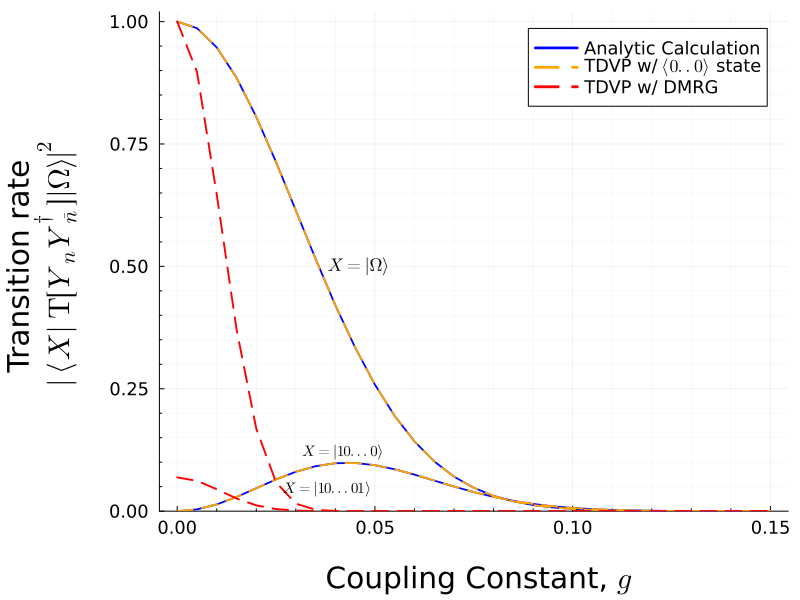

In [118]:
gr()
default(size=(800, 600))
plot(g_list, analytic_expval_list_gs, linewidth=1.8, label="Analytic Calculation", color="blue")
plot!(g_list, analytic_expval_list_p1, linewidth=1.8, label="", color="blue")
#plot!(g_list, analytic_expval_list_p1p2, linewidth=1.8, label="", color="blue")

plot!(g_list, exp_val_list_gs, linewidth=1.9, label="TDVP w/ \$\\langle0..0\\rangle\$ state", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_p1, linewidth=1.9, label="", linestyle=:dash, color="orange")
#plot!(g_list, exp_val_list_p1p2, linewidth=1.9, label="", linestyle=:dash, color="orange")

plot!(g_list, exp_val_list_gs_dmrg, linewidth=1.9, label="TDVP w/ DMRG", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_p1_dmrg, linewidth=1.9, label="", linestyle=:dash, color="red")
#plot!(g_list, exp_val_list_p1p2_dmrg, linewidth=1.9, label="", linestyle=:dash, color="red")

# Add text annotations
annotate!(0.046, 0.5, text("\$X = |\\Omega\\rangle\$", 12))
annotate!(0.042, 0.1205, text("\$X = |10...0\\rangle\$", 10))
annotate!(0.038, 0.045, text("\$X = |10...01\\rangle\$", 10))

# Axis labels with larger font via `guidefont`
xlabel!("\n Coupling Constant, \$g\$", guidefont=font(20))
ylabel!("Transition rate \n \$|\\langle X | \\mathrm{T}[Y_{n}Y_{\\bar{n}}^\\dag] | \\Omega\\rangle|^2\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Set y-limits
ylims!(0, 1.02)

# Add legend
plot!(legend=:topright, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("Transition Rates, N=51 (TDVP)")

In [ ]:
#= exp_val_list_gs_2 = []
exp_val_list_p1_2 = []
exp_val_list_p1p2_2 = []
dt = dx #n_0*dt = n_0*dx is the total evolution time. But since n_0 is already hardcoded into the operator, we only need to input dt=dx into the time evolution operator function (tebdTEO)
num_steps = 1 #Number of steps in the TEBD algorithm. To reduce trotter error, we want to break down the full application of dt into smaller steps
step_width = dt/num_steps #Width of each step
for g in g_list
    Psi = copy(psi_gs)
    for t_step in 1:num_steps
        for i in 1:N
            Psi = apply(tebdTEO(g, step_width)[i], Psi; maxdim=100, cutoff=1e-15)
        end
    end
    normalize!(Psi)

    exp_val_gs_2 = abs2(inner(psi_gs, Psi))
    exp_val_p1_2 = abs2(inner(psi_p1, Psi))
    exp_val_p1p2_2 = abs2(inner(psi_p1p2, Psi))
    push!(exp_val_list_gs_2, exp_val_gs_2)
    push!(exp_val_list_p1_2, exp_val_p1_2)
    push!(exp_val_list_p1p2_2, exp_val_p1p2_2)
end =#

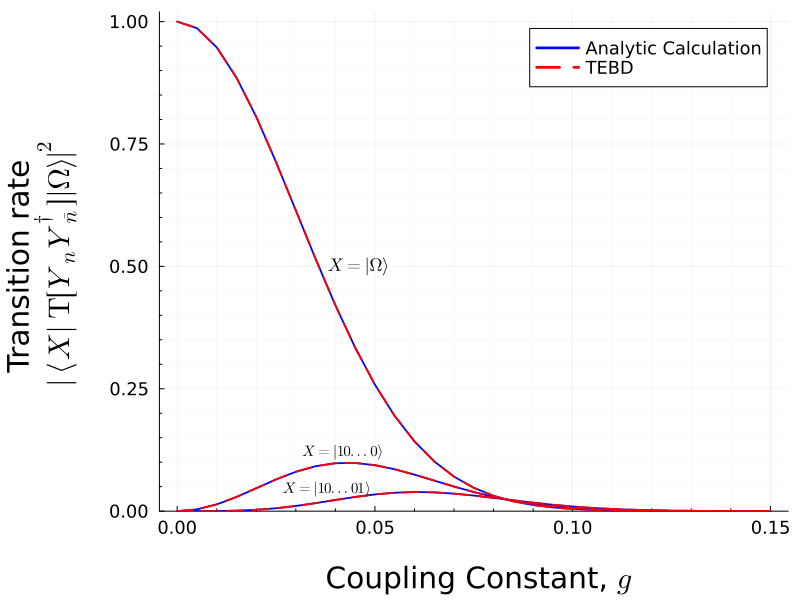

In [ ]:
#= gr()
default(size=(800, 600))
plot(g_list, analytic_expval_list_gs, linewidth=1.8, label="Analytic Calculation", color="blue")
plot!(g_list, analytic_expval_list_p1, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_expval_list_p1p2, linewidth=1.8, label="", color="blue")

plot!(g_list, exp_val_list_gs_2, linewidth=1.9, label="TEBD", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_p1_2, linewidth=1.9, label="", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_p1p2_2, linewidth=1.9, label="", linestyle=:dash, color="red")

# Add text annotations
annotate!(0.046, 0.5, text("\$X = |\\Omega\\rangle\$", 12))
annotate!(0.042, 0.1205, text("\$X = |10...0\\rangle\$", 10))
annotate!(0.038, 0.045, text("\$X = |10...01\\rangle\$", 10))

# Axis labels with larger font via `guidefont`
xlabel!("\n Coupling Constant, \$g\$", guidefont=font(20))
ylabel!("Transition rate \n \$|\\langle X | \\mathrm{T}[Y_{n}Y_{\\bar{n}}^\\dag] | \\Omega\\rangle|^2\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Set y-limits
ylims!(0, 1.02)

# Add legend
plot!(legend=:topright, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("Transition Rates, N=51 (TEBD)") =#

### N=101

In [59]:
N = 101 #Number of lattice sites per dimension

n_0 = round(Int, ((N-1)/2)) #Index of thepoint at the center of the lattice.
dp = (2*pi)/(N*dx) #Discrete change in momentum
p_i = range(1/2*dp, stop = dp*(N+1/2), length = (N+1))[1:end-1]

om_i = Float64[] #List of omega values for each lattice site (eq. 12)
for i in 1:N
    push!(om_i, (2/dx)*abs(sin(p_i[i]*dx/2)))
end

H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
for i in 1:N
    H += (om_i[i]*dp)/(2pi), "a", i, "a†", i
    H += (om_i[i]*dp)/(2pi)*(1/2)*(2pi/dp), "Id", i
end

sites = siteinds("Boson", N; dim=9) #Create ITensor "SFT" sites

psi00000 = MPS(sites, MakeState(Dict()))
psi10000 = MPS(sites, MakeState(Dict(1=>"1")))
psi10001 = MPS(sites, MakeState(Dict(1=>"1", N=>"1")))
psi_ansatz = random_mps(sites,linkdims=4)
energy, psi_dmrg = dmrg(MPO(H, sites), psi_ansatz; nsweeps=(n_0+1), maxdim=200, cutoff=1e-8);

After sweep 1 energy=65.20589858038714  maxlinkdim=20 maxerr=9.90E-09 time=1.937
After sweep 2 energy=64.63142063785028  maxlinkdim=48 maxerr=9.98E-09 time=7.903
After sweep 3 energy=64.45881844434805  maxlinkdim=73 maxerr=9.99E-09 time=14.716
After sweep 4 energy=64.39282222768912  maxlinkdim=43 maxerr=9.99E-09 time=10.993
After sweep 5 energy=64.3569683750975  maxlinkdim=36 maxerr=9.99E-09 time=5.317
After sweep 6 energy=64.33283197486767  maxlinkdim=29 maxerr=1.00E-08 time=2.902
After sweep 7 energy=64.31500371078072  maxlinkdim=26 maxerr=9.98E-09 time=1.871
After sweep 8 energy=64.30362139059139  maxlinkdim=21 maxerr=9.98E-09 time=0.986
After sweep 9 energy=64.30161211135069  maxlinkdim=16 maxerr=9.92E-09 time=0.578
After sweep 10 energy=64.30126487894348  maxlinkdim=13 maxerr=1.00E-08 time=0.335
After sweep 11 energy=64.30119081376252  maxlinkdim=6 maxerr=9.23E-09 time=0.219
After sweep 12 energy=64.3011892126668  maxlinkdim=3 maxerr=9.70E-09 time=0.255
After sweep 13 energy=64.30

In [60]:
g_list = range(0, stop=0.06, length=31)
ITensors.set_warn_order(N)
ITensors.set_warn_order(N)

101

In [61]:
exp_val_list_00000 = []
exp_val_list_10000 = []
exp_val_list_10001 = []
exp_val_list_00000_dmrg = []
exp_val_list_10000_dmrg = []
exp_val_list_10001_dmrg = []
for g in g_list
    Psi = tdvp(MakeMPO(g), dx, psi00000; nsteps=1, maxdim=300, cutoff=1e-15)
    Psi_dmrg = tdvp(MakeMPO(g), dx, psi_dmrg; nsteps=1, maxdim=300, cutoff=1e-15, normalize=true)

    exp_val_00000 = abs2(inner(psi00000, Psi))
    exp_val_10000 = abs2(inner(psi10000, Psi))
    exp_val_10001 = abs2(inner(psi10001, Psi))
    exp_val_00000_dmrg = abs2(inner(psi_dmrg, Psi_dmrg))
    exp_val_10000_dmrg = abs2(inner(psi10000, Psi_dmrg))
    exp_val_10001_dmrg = abs2(inner(psi10001, Psi_dmrg))

    push!(exp_val_list_00000, exp_val_00000)
    push!(exp_val_list_10000, exp_val_10000)
    push!(exp_val_list_10001, exp_val_10001)
    push!(exp_val_list_00000_dmrg, exp_val_00000_dmrg)
    push!(exp_val_list_10000_dmrg, exp_val_10000_dmrg)
    push!(exp_val_list_10001_dmrg, exp_val_10001_dmrg)
end

In [ ]:
#= exp_val_list_00000_2 = []
exp_val_list_10000_2 = []
exp_val_list_10001_2 = []
dt = dx #n_0*dt = n_0*dx is the total evolution time. But since n_0 is already hardcoded into the operator, we only need to input dt=dx into the time evolution operator function (tebdTEO)
num_steps = 1 #Number of steps in the TEBD algorithm. To reduce trotter error, we want to break down the full application of dt into smaller steps
step_width = dt/num_steps #Width of each step
for g in g_list
    Psi = copy(psi00000)
    for t_step in 1:num_steps
        for i in 1:N
            Psi = apply(tebdTEO(g, step_width)[i], Psi; maxdim=100, cutoff=1e-15)
        end
    end
    normalize!(Psi)

    exp_val_00000_2 = abs2(inner(psi00000, Psi))
    exp_val_10000_2 = abs2(inner(psi10000, Psi))
    exp_val_10001_2 = abs2(inner(psi10001, Psi))
    push!(exp_val_list_00000_2, exp_val_00000_2)
    push!(exp_val_list_10000_2, exp_val_10000_2)
    push!(exp_val_list_10001_2, exp_val_10001_2)
end =#

In [62]:
analytic_00000 = [1.000000000000000000e+00, 9.908232690580748292e-01, 9.637952664909003042e-01, 9.203770382643921000e-01,
 8.628576543282623357e-01, 7.941543723344067773e-01, 7.175680628197959043e-01, 6.365223615483031061e-01,
 5.543149913457101619e-01, 4.739057492787654979e-01, 3.977587345319131829e-01, 3.277478621707901052e-01,
 2.651260517527713745e-01, 2.105510132192215111e-01, 1.641552063982073262e-01, 1.256447602092179150e-01,
 9.441184759630143197e-02, 6.964677416800643672e-02, 5.043916749037805070e-02, 3.586139736730002692e-02,
 2.503104039189176996e-02, 1.715232465794841801e-02, 1.153876876487479157e-02, 7.620585614950455174e-03,
 4.940940425370784171e-03, 3.145019067826486815e-03, 1.965302210993053692e-03, 1.205668174349711769e-03,
 7.261371327676177179e-04, 4.293405313279478452e-04, 2.492169216752571320e-04]

analytic_10000 = [0.000000000000000000e+00, 2.260610607271971127e-03, 8.795779714536123076e-03, 1.889895750663164731e-02,
 3.149841513584319963e-02, 4.529752817617135885e-02, 5.893796895637732486e-02, 7.116055215259625699e-02,
 8.094055201733692251e-02, 8.758032654955788532e-02, 9.075055486663341497e-02, 9.048046038224337451e-02,
 8.710527581914363771e-02, 8.118459044467558894e-02, 7.340747682520110118e-02, 6.449951719250751614e-02,
 5.514371561822246220e-02, 4.592280556378730560e-02, 3.728571570543796898e-02, 2.953683615438552554e-02,
 2.284380562630774006e-02, 1.725802690344005116e-02, 1.274190596606940631e-02, 9.197580179584077115e-03,
 6.493243130391545756e-03, 4.484694500286589072e-03, 3.031137255717954778e-03, 2.005325559409066455e-03,
 1.298865772584815960e-03, 8.238107390298614113e-04, 5.117402778274473575e-04]

analytic_10001 = [0.000000000000000000e+00, 5.157691060857568287e-06, 8.027196592106829989e-05, 3.880698670090713628e-04,
 1.149842214521814687e-03, 2.583711845392962919e-03, 4.840912471846199432e-03, 7.955453709976306395e-03,
 1.181886303483585011e-02, 1.618531450652484563e-02, 2.070517249179603531e-02, 2.497869446579800701e-02,
 2.861781792233743585e-02, 3.130328192155173300e-02, 3.282660216557857502e-02, 3.311071397756007451e-02,
 3.220813329684790727e-02, 3.027999639670549484e-02, 2.756240169768733525e-02, 2.432768252378595189e-02,
 2.084769339677796859e-02, 1.736438054545794141e-02, 1.407049321781910813e-02, 1.110091604953737654e-02,
 8.533235117323368160e-03, 6.395027924202789128e-03, 4.675002659442777445e-03, 3.335354357668263506e-03,
 2.323324643600392907e-03, 1.580712940475981123e-03, 1.050803894817992383e-03]

31-element Vector{Float64}:
 0.0
 5.157691060857568e-6
 8.02719659210683e-5
 0.00038806986700907136
 0.0011498422145218147
 0.002583711845392963
 0.004840912471846199
 0.007955453709976306
 0.01181886303483585
 0.016185314506524846
 0.020705172491796035
 0.024978694465798007
 0.028617817922337436
 ⋮
 0.024327682523785952
 0.02084769339677797
 0.01736438054545794
 0.014070493217819108
 0.011100916049537377
 0.008533235117323368
 0.006395027924202789
 0.0046750026594427774
 0.0033353543576682635
 0.002323324643600393
 0.0015807129404759811
 0.0010508038948179924

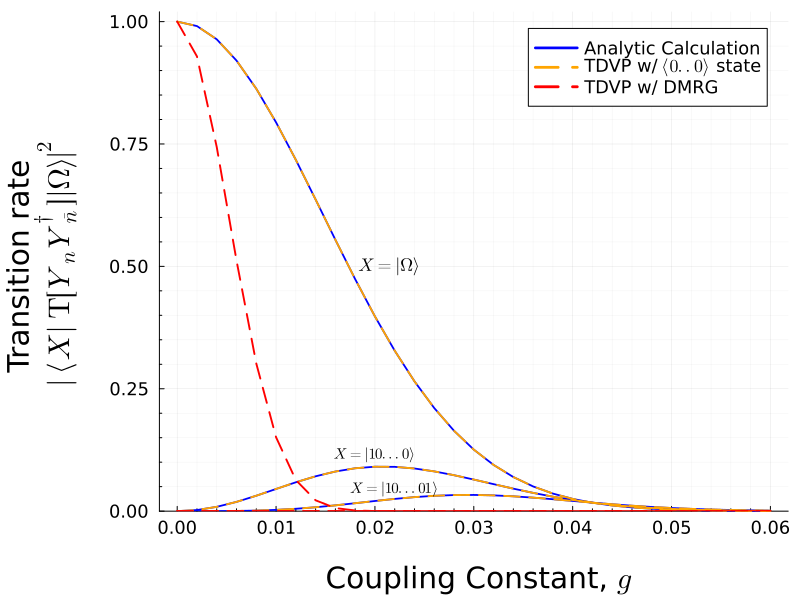

In [63]:
gr()
default(size=(800, 600))
plot(g_list, analytic_00000, linewidth=1.8, label="Analytic Calculation", color="blue")
plot!(g_list, analytic_10000, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_10001, linewidth=1.8, label="", color="blue")

plot!(g_list, exp_val_list_00000, linewidth=1.9, label="TDVP w/ \$\\langle0..0\\rangle\$ state", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_10000, linewidth=1.9, label="", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_10001, linewidth=1.9, label="", linestyle=:dash, color="orange")

plot!(g_list, exp_val_list_00000_dmrg, linewidth=1.9, label="TDVP w/ DMRG", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_10000_dmrg, linewidth=1.9, label="", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_10001_dmrg, linewidth=1.9, label="", linestyle=:dash, color="red")

# Add text annotations
annotate!(0.0215, 0.5, text("\$X = |\\Omega\\rangle\$", 12))
annotate!(0.020, 0.115, text("\$X = |10...0\\rangle\$", 10))
annotate!(0.022, 0.045, text("\$X = |10...01\\rangle\$", 10))

# Axis labels with larger font via `guidefont`
xlabel!("\n Coupling Constant, \$g\$", guidefont=font(20))
ylabel!("Transition rate \n \$|\\langle X | \\mathrm{T}[Y_{n}Y_{\\bar{n}}^\\dag] | \\Omega\\rangle|^2\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Set y-limits
ylims!(0, 1.02)

# Add legend
plot!(legend=:topright, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("Transition Rates, N=101 (TDVP)")

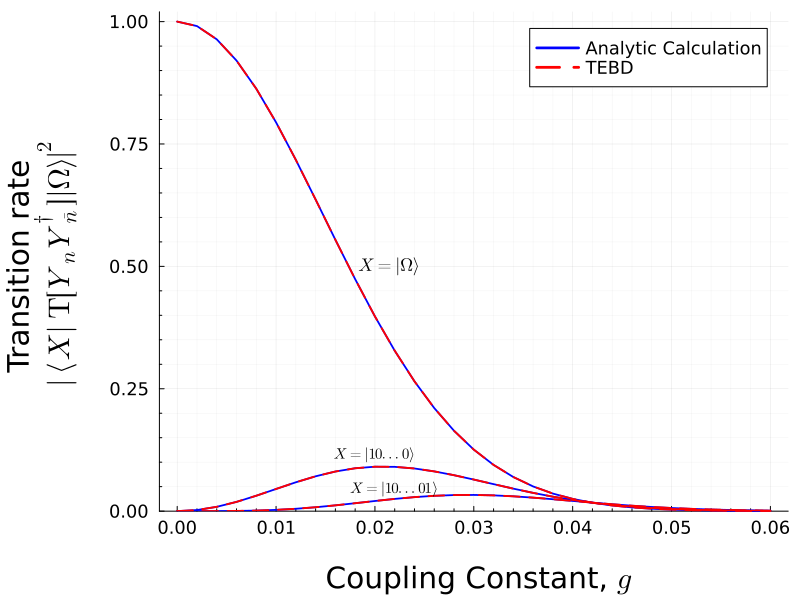

In [ ]:
#= gr()
default(size=(800, 600))
plot(g_list, analytic_00000, linewidth=1.8, label="Analytic Calculation", color="blue")
plot!(g_list, analytic_10000, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_10001, linewidth=1.8, label="", color="blue")

plot!(g_list, exp_val_list_00000_2, linewidth=1.9, label="TEBD", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_10000_2, linewidth=1.9, label="", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_10001_2, linewidth=1.9, label="", linestyle=:dash, color="red")

# Add text annotations
annotate!(0.0215, 0.5, text("\$X = |\\Omega\\rangle\$", 12))
annotate!(0.020, 0.115, text("\$X = |10...0\\rangle\$", 10))
annotate!(0.022, 0.045, text("\$X = |10...01\\rangle\$", 10))

# Axis labels with larger font via `guidefont`
xlabel!("\n Coupling Constant, \$g\$", guidefont=font(20))
ylabel!("Transition rate \n \$|\\langle X | \\mathrm{T}[Y_{n}Y_{\\bar{n}}^\\dag] | \\Omega\\rangle|^2\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Set y-limits
ylims!(0, 1.02)

# Add legend
plot!(legend=:topright, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("Transition Rates, N=101 (TEBD)") =#

### Energy/site for DMRG ground state and |0> ansatz ###

In [23]:
N_list = [101, 125, 151, 175, 201, 225, 251, 275, 301]
energy_list_dmrg = []
energy_list_0 = []

for N in N_list
    dx = 1
    n_0 = round(Int, ((N-1)/2)) #Index of thepoint at the center of the lattice.
    dp = (2*pi)/(N*dx) #Discrete change in momentum
    p_i = range(1/2*dp, stop = dp*(N+1/2), length = (N+1))[1:end-1]

    om_i = Float64[] #List of omega values for each lattice site (eq. 12)
    for i in 1:N
        push!(om_i, (2/dx)*abs(sin(p_i[i]*dx/2)))
    end

    H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
    for i in 1:N
        H += (om_i[i]*dp)/(2pi), "a", i, "a†", i
        H += (om_i[i]*dp)/(2pi)*(1/2)*(2pi/dp), "Id", i
    end

    sites = siteinds("Boson", N; dim=9)

    psi_ansatz = random_mps(sites,linkdims=4)
    energy_dmrg, psi_dmrg = dmrg(MPO(H, sites), psi_ansatz; nsweeps=(n_0+1), maxdim=200, cutoff=1e-8);
    push!(energy_list_dmrg, energy_dmrg)

    vac_state = ["0" for i in 1:N]
    psi_vac = MPS(sites, vac_state)
    energy_0, psi_dmrg = dmrg(MPO(H, sites), psi_vac; nsweeps=(n_0+1), maxdim=200, cutoff=1e-8);
    push!(energy_list_0, energy_0)
end

After sweep 1 energy=65.16133387750388  maxlinkdim=20 maxerr=9.96E-09 time=0.956
After sweep 2 energy=64.59477631055756  maxlinkdim=47 maxerr=9.98E-09 time=4.912
After sweep 3 energy=64.41548425619553  maxlinkdim=60 maxerr=9.97E-09 time=9.115
After sweep 4 energy=64.34954932493916  maxlinkdim=64 maxerr=9.96E-09 time=7.469
After sweep 5 energy=64.32185130646155  maxlinkdim=47 maxerr=9.99E-09 time=4.330
After sweep 6 energy=64.30890542558849  maxlinkdim=38 maxerr=1.00E-08 time=1.644
After sweep 7 energy=64.30342790894534  maxlinkdim=24 maxerr=9.99E-09 time=0.801
After sweep 8 energy=64.30170257823679  maxlinkdim=19 maxerr=9.95E-09 time=0.417
After sweep 9 energy=64.30126570080324  maxlinkdim=10 maxerr=1.00E-08 time=0.218
After sweep 10 energy=64.30119129867238  maxlinkdim=7 maxerr=9.99E-09 time=0.158
After sweep 11 energy=64.30118917828082  maxlinkdim=4 maxerr=8.81E-09 time=0.107
After sweep 12 energy=64.3011891566365  maxlinkdim=1 maxerr=3.68E-09 time=0.085
After sweep 13 energy=64.3011

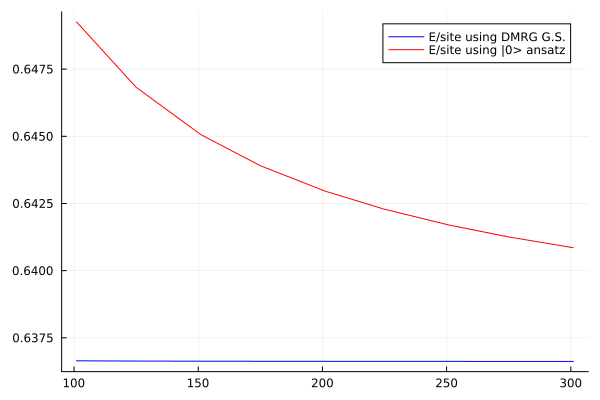

In [24]:
EperS_dmrg = energy_list_dmrg ./ N_list
EperS_0 = energy_list_0 ./ N_list

plot(N_list, EperS_dmrg, label="E/site using DMRG G.S.", color="blue")
plot!(N_list, EperS_0, label="E/site using |0> ansatz", color="red")

In [26]:
using Statistics

print("Average E/site using DMRG ground state: $(mean(EperS_dmrg)) \nAverage E/site using |0> ansatz: $(mean(EperS_0))")

Average E/site using DMRG ground state: 0.636629173406261 
Average E/site using |0> ansatz: 0.6437877507090088